In [3]:
import pandas as pd
import numpy as np
pd.set_option('display.max_columns', None)  
pd.set_option('display.expand_frame_repr', False)
pd.set_option('max_colwidth', -1)
import re
# import nltk
# from nltk.corpus import stopwords
# nltk.download('stopwords')

In [5]:
# import dill
# dill.dump_session('notebook_env.db')

In [6]:
# import dill
# dill.load_session('notebook_env.db')

In [65]:
import numpy as np
import pandas as pd
import glob
all_data = pd.DataFrame()
for f in glob.glob(r"C:\Users\kasandeep\Desktop\Projects\Twitter_Sector_Classification\Intersected\*.xlsx"):
    df = pd.read_excel(f)
    all_data = all_data.append(df,ignore_index=True)

# now save the data frame
writer = pd.ExcelWriter(r'C:\Users\kasandeep\Desktop\Projects\Twitter_Sector_Classification\Intersected\output3.xlsx')
all_data.to_excel(writer,'sheet1')
writer.save()  

In [4]:
#tweets_final0=pd.read_excel('output.xlsx')
tweets_final=pd.read_excel('output3.xlsx')

In [5]:
tweets_final.shape

(65438, 13)

In [68]:
tweets_final['Sector_key'].value_counts()

Technology              40011
Travel and Tourism      8499 
Automotive              5352 
Mining                  3731 
ADS                     2499 
Pharma                  1990 
Power                   1145 
Banking and Payments    533  
Oil and Gas             492  
Consumer                373  
Retail                  334  
Construction            256  
Packaging               95   
Insurance               69   
Foodservices            56   
Medical Devices         3    
Name: Sector_key, dtype: int64

In [73]:
g=pd.concat([tweets_final0,tweets_final]).drop_duplicates()

C:\Users\kasandeep\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  """Entry point for launching an IPython kernel.


In [69]:
g=tweets_final.drop_duplicates()

In [75]:
g.to_excel('Final_data_refined_Nov.xlsx')

In [74]:
g['Sector_key'].value_counts()

Technology              62676
Travel and Tourism      12581
Automotive              5377 
ADS                     4418 
Mining                  3739 
Pharma                  2320 
Power                   1360 
Foodservices            912  
Banking and Payments    533  
Oil and Gas             497  
Consumer                389  
Retail                  350  
Construction            259  
Packaging               95   
Insurance               69   
Medical Devices         3    
Name: Sector_key, dtype: int64

In [874]:
tweets_final['Sector_key'].value_counts()

Technology              26571
Travel and Tourism      5342 
Automotive              3645 
ADS                     2127 
Foodservices            1431 
Pharma                  611  
Power                   550  
Banking and Payments    315  
Construction            171  
Retail                  82   
Consumer                31   
Mining                  28   
Oil and Gas             10   
Name: Sector_key, dtype: int64

In [718]:
tweets_final1=tweets_final.drop(['Companies','Sectors','Locations','Sector_hash','ScreenName','Sector_inf','Sector_hash','Themes','Tweethistoryid','id'],axis=1)

In [719]:
tweets_final1.dropna(inplace=True)

In [568]:
tweets_copy

,Sector_key,TweetFulltext
0,ADS,expans product line use near everi aircraft fli around world meet us today mroam stand 3843 learn capabl https: co 0vre1p5i1p aviat https: co fgvcrlfmdi
1,ADS,attend mroam meet parker aerospac team stand 3843 learn world-class custom support oper get preview latest product innov aerospac industri https: co g41j6wuy0w aviat https: co b2wvatqb8x
2,ADS,attend asian busi aviat confer &amp; exhibit abac shanghai meet parker aerospac team booth c821 learn latest product &amp; technolog aviat industri more: https: co ekpl47bfan https: co rjqtcxa3cx
3,ADS,world-class custom support oper dedic keep aircraft fleet healthi around globe clock 24 7 full spectrum support services: https: co g41j6wuy0w learn mroam booth 3843 @avweekev aviat https: co ag5gwwzxyq
4,ADS,attend snf19 week come talk aerospac team booth c-032 + c-033 check newest product general aviat support servic https: co as5ghrkegz https: co qljwbidqar
5,ADS,go first week april want hype thing wendi goodson afrl inspir talk cook aircraft check here: https: co oc0ur7xbhw afresearchlab airforc inspir stem throwbackthursday https: co gp1o186kti
6,ADS,showcas de&amp; collabor @britisharmi deliv ajax sent photographi team document cold weather train sweden watch vehicl put pace demonstr real-world benefit https: co yst2iplbmw … defenc @defencehq https: co sh0i0lwpva
7,ADS,italian eurofight conduct first scrambl montenegro detail 👉https: co y3p9dwfudg eurofight aeronauticamilitar aviat aviationdaili aviationlov aerospac defenc militarynew avgeek avgeek @ldo_aircraft https: co c6qaz1ars0
8,ADS,welcom mediterranean ✈️ e-2d hawkey bluetail carrier airborn earli warn squadron 121 launch flight deck ussabrahamlincoln @cvn_72 first time us6thfleet area respons abecsg steadypres navyreadi https: co eembgzo0r0
9,ADS,@usarmi maj gen roger l cloutier jr @usarmyafrica command general give remark open ceremoni exercis phoenixexpress 2019 maritimesecur navypartnership oneteam https: co ozfjfpcixp


In [659]:
# from twitter_preprocessor import TwitterPreprocessor
# p=TwitterPreprocessor('Sandeeep is great https//sandeep.com')
# p.fully_preprocess()
# p.text

In [660]:
# re.sub(pattern=re.compile(
#         r'((https?|https?:)\/\/(?:www\.|(?!www))[a-zA-Z0-9][a-zA-Z0-9-]+[a-zA-Z0-9]\.[^\s]{2,}|(https?|https?:)\/\/(?:www\.|(?!www))'
#         r'[a-zA-Z0-9]\.[^\s]{2,}|www\.[a-zA-Z0-9]\.[^\s]{2,})'), repl='', string='httpstcoY3P9DWfUdg')

In [661]:
# from twitter_pre import TwitterPreprocessor
# p=TwitterPreprocessor('Sandeeep is great https://sandeep.com')
# p.remove_urls()
# p.text

In [669]:
# link_regex    = re.compile('((https?):((//)|(\\\\))+([\w\d:#@%/;$()~_?\+-=\\\.&](#!)?)*)')
# links         = re.findall(link_regex, 'Sandeeep is great https//sandeep.com')

In [670]:
links

[]

In [774]:
text=[]
for sentence in tweets_final1['TweetFulltext']:
    p=TwitterPreprocessor(sentence)
    p.remove_urls().remove_numbers().remove_punctuation().remove_stopwords()
    text.append(p.text)
tweets_final1['TweetFulltext1']=text

In [ ]:
from twitter_preprocessor import TwitterPreprocessor
text=[]
for sentence in tweets_final1['TweetFulltext']:
    p = TwitterPreprocessor(sentence)
    #p.fully_preprocess()
    premove_urls().remove_punctuation().remove_mentions().remove_single_letter_words().remove_blank_spaces().remove_stopwords().remove_numbers()
    text.append(p.text)
    print(sentence,p.text)
tweets_final1['TweetFulltext']=text

In [710]:
for i in set(tweets_final1['Sector_key'].values):
    print(i)

Oil and Gas
Construction
Foodservices
Mining
Automotive
Pharma
Travel and Tourism
Consumer
Retail
Technology
ADS
Power


In [744]:
df1 = pd.Series(np.hstack(tweets_final1[tweets_fina1l['Sector_key']=='Power']['TweetFulltext1'].str.findall(r'#.*?(?=\s|$)'))).value_counts().to_frame('count')

df2 = df1.rename_axis('Hashtag').reset_index()

In [745]:
df2.to_excel(r'C:\Users\kasandeep\Desktop\Projects\Twitter_Sector_Classification\New_keywords Generated\Power_newhashtags.xlsx')

In [ ]:
Oil and Gas
Construction
Foodservices
Mining
Automotive
Pharma
Travel and Tourism
Consumer
Retail
Technology
ADS
Power

In [799]:
from collections import Counter
from string import punctuation

import pandas as pd

from nltk.corpus import stopwords
from nltk import word_tokenize

stoplist = set(stopwords.words('english') + list(punctuation))

#df = pd.read_csv("test.csv", sep='\t')

texts = tweets_final1[tweets_fina1l['Sector_key']=='Power']['TweetFulltext1'].str.lower()

word_counts = Counter(word_tokenize('\n'.join(texts)))

word_counts.most_common()

[('energytransition', 339),
 ('rt', 279),
 ('renewableenergy', 234),
 ('renewables', 195),
 ('profstrachan', 183),
 ('’', 150),
 ('amp', 150),
 ('solar', 138),
 ('offshorewind', 129),
 ('windpower', 126),
 ('power', 126),
 ('mzjacobson', 126),
 ('via', 120),
 ('energy', 114),
 ('the', 114),
 ('energystorage', 108),
 ('climatechange', 99),
 ('electricity', 72),
 ('brianvad', 69),
 ('fossilfuels', 66),
 ('cleanenergy', 63),
 ('climate', 57),
 ('china', 57),
 ('wind', 54),
 ('sustainableenergy', 54),
 ('world', 54),
 ('climateemergency', 54),
 ('“', 51),
 ('new', 51),
 ('us', 48),
 ('we', 48),
 ('climatecrisis', 48),
 ('jellsmoor', 45),
 ('pv', 45),
 ('usa', 45),
 ('coal', 42),
 ('solarpower', 42),
 ('a', 42),
 ('solarenergy', 39),
 ('could', 39),
 ('global', 36),
 ('100', 36),
 ('csikow', 36),
 ('jobs', 36),
 ('uk', 36),
 ('work', 36),
 ('technology', 36),
 ('csp', 36),
 ('mw', 33),
 ('greentechmedia', 33),
 ('clean', 33),
 ('mwt2008', 33),
 ('sethleitman', 33),
 ('wrong', 30),
 ('climat

In [800]:
import csv
with open(r'C:\Users\kasandeep\Desktop\Projects\Twitter_Sector_Classification\New_keywords Generated\Power.csv','w',encoding='utf-8',newline='') as out:
    csv_out=csv.writer(out)
    csv_out.writerow(['name','num'])
    csv_out.writerows(word_counts.most_common())

In [ ]:
tweets_final1.TweetFulltext1[0:3].apply(lambda x: pd.value_counts(x.split(" "))).sum(axis = 0)

In [336]:
tweets_copy=tweets_final

In [341]:
tweets_copy=tweets_copy.drop(['Companies','Sectors','Locations','Sector_hash','ScreenName','Sector_inf','Sector_hash','Themes','Tweethistoryid','id'],axis=1)

In [357]:
train=tweets_copy[tweets_copy['Sector_key']=='Technology']

In [376]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn import svm

In [520]:
import warnings
warnings.filterwarnings("ignore")                     #Ignoring unnecessory warnings

import numpy as np                                  #for large and multi-dimensional arrays
import pandas as pd                                 #for data manipulation and analysis
import nltk                                         #Natural language processing tool-kit

from nltk.corpus import stopwords                   #Stopwords corpus
from nltk.stem import PorterStemmer                 # Stemmer

from sklearn.feature_extraction.text import CountVectorizer          #For Bag of words
from sklearn.feature_extraction.text import TfidfVectorizer          #For TF-IDF
from gensim.models import Word2Vec  

In [521]:
stop = set(stopwords.words('english')) 
print(stop)

{'too', 'mustn', "aren't", 'having', 'to', 'and', 'was', 'these', "didn't", 'hadn', "should've", 'own', 'ourselves', "you'll", 'shan', "weren't", 'yourselves', 'for', "couldn't", 'has', "doesn't", 'just', 'do', 'again', 'few', "you've", 'below', 'where', "that'll", 'aren', 'between', 'haven', 'after', "it's", "shouldn't", 'needn', 'out', 'once', 'that', 'are', 'some', 'your', 'because', 'an', 'be', 'doesn', 'so', 've', 'wasn', 'in', 'myself', 'weren', 'am', 't', 'him', 'against', 'through', 'what', 'those', 'while', 'wouldn', 'my', 'didn', 'did', 'which', 'over', 'ours', 'the', 'ain', 'all', 'o', 'a', 'both', 'being', 'will', 'down', 'if', 'about', 's', 'than', "mustn't", 'not', 'd', 'same', 'me', 'he', 'we', 'her', 'it', 'of', 'how', 'as', "mightn't", 'themselves', 'other', 'at', 'up', 'each', 'ma', 'during', "shan't", 'won', 'hasn', 'most', 'y', 'yours', 'they', 'have', 'm', 'off', "hadn't", 'll', 'under', 'our', 'isn', 'any', 'such', 'himself', 'yourself', 'them', 'or', 'been', "don

In [527]:
import re
temp =[]
snow = nltk.stem.SnowballStemmer('english')
for sentence in tweets_copy['TweetFulltext']:
    sentence = sentence.lower()                 # Converting to lowercase
    cleanr = re.compile('<.*?>')
    sentence = re.sub(cleanr, ' ', sentence)        #Removing HTML tags
    sentence = re.sub(r'[?|!|\'|"|#]',r'',sentence)
    sentence = re.sub(r'[.|,|)|(|\|/]',r' ',sentence)        #Removing Punctuations
    
    words = [snow.stem(word) for word in sentence.split() if word not in stopwords.words('english')]   # Stemming and removing stopwords
    temp.append(words)
    
tweets_copy['TweetFulltext'] = temp 

In [530]:
sent = []
for row in tweets_copy['TweetFulltext']:
    sequ = ''
    for word in row:
        sequ = sequ + ' ' + word
    sent.append(sequ)

tweets_copy['TweetFulltext'] = sent

In [ ]:
from twitter_preprocessor import TwitterPreprocessor
text=[]
for sentence in tweets_copy['TweetFulltext']:
    p = TwitterPreprocessor(sentence)
    p.fully_preprocess()
    text.append(p.text)
tweets_copy['TweetFulltext']=text

In [531]:
tweets_copy

,Sector_key,TweetFulltext
0,ADS,expans product line use near everi aircraft fli around world meet us today mroam stand 3843 learn capabl https: co 0vre1p5i1p aviat https: co fgvcrlfmdi
1,ADS,attend mroam meet parker aerospac team stand 3843 learn world-class custom support oper get preview latest product innov aerospac industri https: co g41j6wuy0w aviat https: co b2wvatqb8x
2,ADS,attend asian busi aviat confer &amp; exhibit abac shanghai meet parker aerospac team booth c821 learn latest product &amp; technolog aviat industri more: https: co ekpl47bfan https: co rjqtcxa3cx
3,ADS,world-class custom support oper dedic keep aircraft fleet healthi around globe clock 24 7 full spectrum support services: https: co g41j6wuy0w learn mroam booth 3843 @avweekev aviat https: co ag5gwwzxyq
4,ADS,attend snf19 week come talk aerospac team booth c-032 + c-033 check newest product general aviat support servic https: co as5ghrkegz https: co qljwbidqar
5,ADS,go first week april want hype thing wendi goodson afrl inspir talk cook aircraft check here: https: co oc0ur7xbhw afresearchlab airforc inspir stem throwbackthursday https: co gp1o186kti
6,ADS,showcas de&amp; collabor @britisharmi deliv ajax sent photographi team document cold weather train sweden watch vehicl put pace demonstr real-world benefit https: co yst2iplbmw … defenc @defencehq https: co sh0i0lwpva
7,ADS,italian eurofight conduct first scrambl montenegro detail 👉https: co y3p9dwfudg eurofight aeronauticamilitar aviat aviationdaili aviationlov aerospac defenc militarynew avgeek avgeek @ldo_aircraft https: co c6qaz1ars0
8,ADS,welcom mediterranean ✈️ e-2d hawkey bluetail carrier airborn earli warn squadron 121 launch flight deck ussabrahamlincoln @cvn_72 first time us6thfleet area respons abecsg steadypres navyreadi https: co eembgzo0r0
9,ADS,@usarmi maj gen roger l cloutier jr @usarmyafrica command general give remark open ceremoni exercis phoenixexpress 2019 maritimesecur navypartnership oneteam https: co ozfjfpcixp


In [526]:
tweets_copy.dropna(inplace=True)

In [532]:
train=tweets_copy[tweets_copy['Sector_key']=='Technology']
train.dropna(inplace=True)
y_map={'Technology':0}
train['Sector_key']=[y_map[i] for i in train['Sector_key']]
test1=train['Sector_key']
train=train.drop(['Sector_key'],axis=1)
#mapper = DataFrameMapper([('Bios',TfidfVectorizer())])
#X=mapper.fit_transform(train)
tfidfconverter = TfidfVectorizer()
X=tfidfconverter.fit_transform(train['TweetFulltext'])
# X_train, X_test, y_train, y_test = train_test_split(X,test1,test_size=0.3)
# from sklearn.ensemble import RandomForestClassifier
#import xgboost as xgb
# rfc = RandomForestClassifier()
# rfc.fit(X_train,y_train)
oneclass = svm.OneClassSVM(nu=0.3,gamma=1)
oneclass.fit(X)
# xgb_model = xgb.XGBClassifier(objective="binary:logistic")
# xgb_model.fit(X_train,y_train)

OneClassSVM(cache_size=200, coef0=0.0, degree=3, gamma=1, kernel='rbf',
            max_iter=-1, nu=0.3, random_state=None, shrinking=True, tol=0.001,
            verbose=False)

In [493]:
# import numpy as np
# import matplotlib.pyplot as plt
# import matplotlib.font_manager
# from sklearn import svm
# %matplotlib inline

In [479]:
# plt.spy(X,markersize=10)

In [491]:
# xx, yy = np.meshgrid(np.linspace(-5, 5, 500), np.linspace(-5, 5, 500))
# # Generate train data
# np.random.seed(17)
# X_train = np.array(X[0:5])
# # Generate some regular novel observations
# X_test = np.array(X[5:10])
# # Generate some abnormal novel observations
# X_outliers = np.random.uniform(low=-4, high=4, size=(20, 2))

# plt.scatter([a[0] for a in X_train],[a[1] for a in X_train])
# plt.scatter([a[0] for a in X_outliers],[a[1] for a in X_outliers])
# plt.scatter([a[0] for a in X_test],[a[1] for a in X_test])
# plt.legend(["positive in train data", "outliers in test data", "positive in test data"], loc="upper left")

In [502]:
oneclass

OneClassSVM(cache_size=200, coef0=0.0, degree=3, gamma=10, kernel='rbf',
            max_iter=-1, nu=0.2, random_state=None, shrinking=True, tol=0.001,
            verbose=False)

In [519]:
oneclass.score_samples(tfidfconverter.transform(['New generation of #prosthetics can read mind using #machineLearning and #EMG #AI #ArtificialIntelligence #ML #DeepLearning #robotics #tech']))

array([3403.52485307])

In [518]:
oneclass.score_samples(tfidfconverter.transform(['How #ArtificialIntelligence is helping #farmers in Indian villages']))

array([3297.28550468])

In [468]:
tfidfconverter.transform(['How #ArtificialIntelligence #machineLearning #ML #DeepLearning #tech is helping #farmers in Indian villages'])

<1x42465 sparse matrix of type '<class 'numpy.float64'>'
	with 11 stored elements in Compressed Sparse Row format>

In [457]:
# %history

In [ ]:
print(y[y == 1].size / y.size)

In [374]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score

In [375]:
predictions=xgb_model.predict(X_test)
print(confusion_matrix(y_test,predictions),
accuracy_score(y_test,predictions),
f1_score(y_test,predictions),sep='\n')

[[23869]]
1.0
0.0


C:\Users\kasandeep\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\kasandeep\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1439: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


In [1]:
df = pd.concat(pd.read_excel(r'C:/Users/kasandeep/Desktop/Projects/Twitter_Sector_Classification/TweetDump_last6months/TweetsDump_Apr.xlsx', sheet_name=None), ignore_index=True)

NameError: name 'pd' is not defined

In [1007]:
df_copy=df.copy()

In [13]:
# df['TweetFulltext'] = df['TweetFulltext'].apply(lambda x: re.sub('[!@#$:\n).;,?&]', '', x.lower()))
# df['TweetFulltext'] = df['TweetFulltext'].apply(lambda x: re.sub('  ', ' ', x))
# df['TweetFulltext'] = df['TweetFulltext'].str.replace('http\S+|www.\S+', '', case=False)

In [14]:
# df['TweetFulltext']  = df['TweetFulltext'] .str.replace(r'[^\x00-\x7F]+', '', regex=True)

In [15]:
# df['TweetFulltext'] = df['TweetFulltext'].apply(lambda x: re.sub('[%]', '', x.lower()))

In [16]:
# df=df[df['TweetFulltext'].apply(lambda x: len(x.split(' ')) > 10)]

In [9]:
df

,id,ScreenName,TweetFulltext,Companies,Locations,Themes,Sectors,Tweethistoryid
0,2400000,activrightbrain,"What an incredible night! The pace never let up – except to sit down for the film, then even more action kicked off – best 4D ever!!",NaN,NaN,NaN,NaN,135721799
1,2400001,activrightbrain,The devil’s in the detail when preparing for a night of Bond! Loved every second at @secretcinema #CasinoRoyale with @VictoriaTaylUK last night. And these are the ONLY details we can reveal! Amazing from start to finish!! #JamesBond #SecretCinema https://t.co/iOhccbXQAP,NaN,NaN,NaN,NaN,135719081
2,2400002,activrightbrain,@Aedwards01 @chevrolet Never – why start now?,NaN,NaN,NaN,Vehicle Manufacturers,135476561
3,2400003,activrightbrain,"Oh, surely this one should be in @kaaimansint - I feel the need for speed and artwork... #cars #Mclaren #MclarenF1 @McLarenAuto https://t.co/vbU8IuFFSp (nice spot @stuartg917 )","Honda Motor Co Ltd, Michelin SCA, Murray & Roberts Holdings Ltd, Sotheby’s, University of Surrey","France, Germany, Italy, Japan, New Zealand, Singapore, United States",NaN,NaN,135482296
4,2400004,activrightbrain,"@Aedwards01 @chevrolet Hah, totally agree on design (inside and out) – but I might be $1,940,000 short...",General Motors Co,NaN,NaN,Vehicle Manufacturers,135475865
5,2400005,activrightbrain,A great opportunity for Screenwriters to dive into Immersive Storytelling with @StoryfuturesA and @AiCharisma! #VR #AR #Innovation #Publishing #Design https://t.co/m3irkeuYjU,NaN,NaN,Alternative Reality,NaN,135465849
6,2400006,activrightbrain,"@ollyog @chevrolet Haha, tried to spec a ‘tasteful’ one in metallic bronze but the configuration wasn’t playing ball!",NaN,NaN,NaN,Vehicle Manufacturers,135448665
7,2400007,activrightbrain,"@mattdesmier Completely agree. No, wait...",NaN,NaN,NaN,NaN,135461397
8,2400008,activrightbrain,"OK, shoot me but I like the new #ChevroletCorvette #Stingray - hints of so many other mid-engines supercars plus just enough ‘Vette, but this one should be a 495bhp steal from $60,000! #cars #Corvette https://t.co/GE8CbpiVJE",NaN,NaN,NaN,Vehicle Manufacturers,135448272
9,2400009,activrightbrain,"An extraordinary opportunity to help patients with Parkinsons, epilepsy, depression, chronic pain and tinnitus. @elonmusk joked about potential for telepathy – but it's a very real possibility with @neuralink tech! #AI #IoT #MedTech #Wearables",NaN,NaN,"Artificial Intelligence, Digital Therapeutics, Internet of Things, MedTech, Wearable Tech",Consumer Electronics,135425821


In [310]:
df.shape

(2450611, 8)

In [839]:
# df1 = pd.Series(np.hstack(df.TweetFulltext.str.findall(r'#.*?(?=\s|$)'))).value_counts().to_frame('count')

# df2 = df1.rename_axis('Hashtag').reset_index()

In [840]:
# df[df['TweetFulltext'].isin(list(df2['Hashtag'][0:50]))]

In [ ]:
# df[df['id']==1084402]

In [5]:
# (df.groupby('title')['scene_text']
#                             .apply(lambda x: np.mean(x.str.len()))
#                             .reset_index(name='mean_len_text'))


In [ ]:
# df['TweetFulltext'].mean()

In [17]:
# df[df['TweetFulltext'].apply(lambda x: len(x.split(' ')) > 10)]

,id,ScreenName,TweetFulltext,Companies,Locations,Themes,Sectors,Tweethistoryid
6,2400006,rdschaller,replace lord with batman and reassess the world we live in,NaN,NaN,NaN,NaN,154800903
7,2400007,abbywaxenberg,"carpedonktum fyi thecryingindianwasn't actually native american at all in fact he was an italian actor that went by the name ""iron eyes cody"" in the 1970's he appeared in a few anti-litteringadvertisementskinda fitting for pocahontasactor espera oscar de corti ( italian",NaN,NaN,NaN,NaN,154800906
8,2400008,abbywaxenberg,this post is dedicated to my trolls i have the most dedicated trolls in congress in the intellectual rummage sale of your replies there sure is the occasional gem that brings smiles amp laughs 2 many happy friday trolls it wouldnt be twitter w/o you,NaN,NaN,NaN,NaN,154800907
9,2400009,abbywaxenberg,realdonaldtrump watch christian boys in africa chained and forced to learn quran christian girls given to fighters as sex slaves some just 9 years olddon't wait on the media to report rt this yourself send to your reps in governmentccotmaga,NaN,NaN,NaN,NaN,154800908
10,2400010,abbywaxenberg,anyone surprised the investigation in spygate is now focused on brennan me neither,NaN,NaN,NaN,NaN,154800909
11,2400011,abbywaxenberg,ilhan rashidatlaib are radical islamists with a searing hatred of israel amp usaworst they are mainstreaming hate of israel no dem in congress will criticize them many join them amp their radical dangerous policiesthe dem party must wake up to this before it's too late,NaN,"Israel, United States",NaN,NaN,154800910
12,2400012,abbywaxenberg,epstein butler alfredo rodriguez served more time in prison than epstein - he died before disclosing location of epstein's black bookbluestarzone,NaN,NaN,NaN,NaN,154800911
17,2400017,abbywaxenberg,they didn't ask menbc news report heterosexuality is just not working via breitbartnews,NaN,NaN,NaN,NaN,154800916
18,2400018,abbywaxenberg,no president has ever taken this on realdonaldtrump is the only oneaccording to former microsoft ceo 90 of chinese companies use windows but only 1 were paying for it this piracy cost microsoft 10 billion or more in profittradewar china,NaN,China,NaN,NaN,154800917
19,2400019,abbywaxenberg,factinate you know i don't want a bunch of stories just want the picture explained,NaN,NaN,NaN,NaN,154800918


In [8]:
# stopword_set = set(stopwords.words("english"))

In [28]:
# nltk.download('words')

[nltk_data] Downloading package words to
[nltk_data]     C:\Users\kasandeep\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping corpora\words.zip.


True

In [29]:
# words = set(nltk.corpus.words.words())

In [11]:
#df['TweetFulltext'].apply(lambda x: [item for item in x if item not in stopword_set]).str.join('')

In [32]:
# [" ".join(w for w in nltk.wordpunct_tokenize(x) 
#                        if w.lower() in words or not w.isalpha()) 
#                        for x in df['TweetFulltext']]

['replace lord with batman and reassess the world we live in',
 '\' t actually native at all in fact he was an actor that went by the name " iron " in the 1970 \' s he in a few anti - fitting for de (',
 'this post is to my i have the most in congress in the intellectual rummage sale of your there sure is the occasional gem that 2 many happy it wouldnt be twitter w / o you',
 "watch in chained and forced to learn given to as sex some just 9 ' t wait on the media to report this yourself send to your reps in",
 'anyone the investigation in is now on me neither',
 "are radical with a searing hatred of they are hate of no in congress will criticize them many join them their radical dangerous party must wake up to this before it ' s too late",
 "butler more time in prison than - he before location of ' s black",
 "they ' t ask news report heterosexuality is just not working via",
 'no president ever taken this on is the only to former 90 of use but only 1 were paying for it this piracy cost

In [338]:
# df['Sector']=''

In [337]:
# df_technology
# df_Foodservices
# df_Pharma
# df_Travel_and_Tourism
# df_ADS
# df_Medical_Devices
# df_Healthcare
# df_Consumer
# df_Retail
# df_Packaging
# df_Insurance
# df_Banking_Payments
# df_Oil_Gas
# df_Power
# df_Construction
# df_Automotive

In [333]:
# df_Influencer=pd.concat([df_technology,df_Foodservices,df_Pharma,df_Travel_and_Tourism,df_ADS,df_Medical_Devices,df_Healthcare,df_Consumer,df_Retail,df_Packaging,df_Insurance,df_Banking_Payments,df_Oil_Gas,df_Power,df_Construction,df_Automotive])

In [164]:
# df_Influencer.to_excel('Influencer_Aug.xlsx')

In [336]:
# df_Automotive['Sector']='Automotive'

In [334]:
# df_Automotive

In [335]:
# df_Automotive=df[df['ScreenName'].isin(list(df2[df2['Sector']=='Automotive']['ScreenName']))]

In [339]:
# df['Sector_Key']=''

In [ ]:
# df_search=df['TweetFulltext'].apply(lambda x: re.search(r'\b' + '|'.join(list(df5['Keyword'].dropna())) + '\W', x))

In [ ]:
# import re

# s = '${test}= Test word browser mozilla'
# target = 'Test word'
# pattern = r'{}(\s+)'.format(target)
# count = len(re.findall(pattern, s)[0])

In [ ]:
# re.search(r'\b' + string1 + '\W', string2)

In [ ]:
# Technology              3529
# Foodservices            1517
# Pharma                  928 
# Travel and Tourism      858 
# ADS                     773 
# Power                   273 
# Packaging               57  
# Consumer                56  
# Retail                  52  
# Automotive              50  
# Mining                  45  
# Oil and Gas             31  
# Banking and Payments    31  
# Construction            30  

In [54]:
df = pd.concat(pd.read_excel(r'C:/Users/kasandeep/Desktop/Projects/Twitter_Sector_Classification/TweetDump_last6months/TweetsDump_AUG.xlsx', sheet_name=None), ignore_index=True)

In [55]:
df_copy=df.copy()

In [56]:
df_copy['Sector_key']=''
df_copy['Sector_hash']=''

In [57]:
for i in range(0,16):
    if i==0:
        df5=pd.read_excel('Sector Top Keywords_Without Spaces_1_11_2019.xlsx',sheetname=0)
        df_copy.loc[df_copy['TweetFulltext'].str.contains('|'.join(list(df5['Keyword'].dropna())))==True,'Sector_key']='Oil and Gas'
        df_copy.loc[df_copy['TweetFulltext'].str.contains('|'.join(list(df5['#tags'].dropna())))==True,'Sector_hash']='Oil and Gas'
    elif i==1:
        df5=pd.read_excel('Sector Top Keywords_Without Spaces_1_11_2019.xlsx',sheetname=1)
        df_copy.loc[df_copy['TweetFulltext'].str.contains('|'.join(list(df5['Keyword'].dropna())))==True,'Sector_key']='Technology'
        df_copy.loc[df_copy['TweetFulltext'].str.contains('|'.join(list(df5['#tags'].dropna())))==True,'Sector_hash']='Technology'
    elif i==2:
        df5=pd.read_excel('Sector Top Keywords_Without Spaces_1_11_2019.xlsx',sheetname=2)
        df_copy.loc[df_copy['TweetFulltext'].str.contains('|'.join(list(df5['Keyword'].dropna())))==True,'Sector_key']='Travel and Tourism'
        df_copy.loc[df_copy['TweetFulltext'].str.contains('|'.join(list(df5['#tags'].dropna())))==True,'Sector_hash']='Travel and Tourism'
    elif i==3:
        df5=pd.read_excel('Sector Top Keywords_Without Spaces_1_11_2019.xlsx',sheetname=3)
        df_copy.loc[df_copy['TweetFulltext'].str.contains('|'.join(list(df5['Keyword'].dropna())))==True,'Sector_key']='Retail'
        df_copy.loc[df_copy['TweetFulltext'].str.contains('|'.join(list(df5['#tags'].dropna())))==True,'Sector_hash']='Retail'
    elif i==4:
        df5=pd.read_excel('Sector Top Keywords_Without Spaces_1_11_2019.xlsx',sheetname=4)
        df_copy.loc[df_copy['TweetFulltext'].str.contains('|'.join(list(df5['Keyword'].dropna())))==True,'Sector_key']='Power'
        df_copy.loc[df_copy['TweetFulltext'].str.contains('|'.join(list(df5['#tags'].dropna())))==True,'Sector_hash']='Power'
    elif i==5:
        df5=pd.read_excel('Sector Top Keywords_Without Spaces_1_11_2019.xlsx',sheetname=5)
        df_copy.loc[df_copy['TweetFulltext'].str.contains('|'.join(list(df5['Keyword'].dropna())))==True,'Sector_key']='Pharma'
        df_copy.loc[df_copy['TweetFulltext'].str.contains('|'.join(list(df5['#tags'].dropna())))==True,'Sector_hash']='Pharma'
    elif i==6:
        df5=pd.read_excel('Sector Top Keywords_Without Spaces_1_11_2019.xlsx',sheetname=6)
        df_copy.loc[df_copy['TweetFulltext'].str.contains('|'.join(list(df5['Keyword'].dropna())))==True,'Sector_key']='Packaging'
        df_copy.loc[df_copy['TweetFulltext'].str.contains('|'.join(list(df5['#tags'].dropna())))==True,'Sector_hash']='Packaging'
    elif i==7:
        df5=pd.read_excel('Sector Top Keywords_Without Spaces_1_11_2019.xlsx',sheetname=7)
        df_copy.loc[df_copy['TweetFulltext'].str.contains('|'.join(list(df5['Keyword'].dropna())))==True,'Sector_key']='Mining'
        df_copy.loc[df_copy['TweetFulltext'].str.contains('|'.join(list(df5['#tags'].dropna())))==True,'Sector_hash']='Mining'
    elif i==8:
        df5=pd.read_excel('Sector Top Keywords_Without Spaces_1_11_2019.xlsx',sheetname=8)
        df_copy.loc[df_copy['TweetFulltext'].str.contains('|'.join(list(df5['Keyword'].dropna())))==True,'Sector_key']='Consumer'
        df_copy.loc[df_copy['TweetFulltext'].str.contains('|'.join(list(df5['#tags'].dropna())))==True,'Sector_hash']='Consumer'
    elif i==9:
        df5=pd.read_excel('Sector Top Keywords_Without Spaces_1_11_2019.xlsx',sheetname=10)
        df_copy.loc[df_copy['TweetFulltext'].str.contains('|'.join(list(df5['Keyword'].dropna())))==True,'Sector_key']='Foodservices'
        df_copy.loc[df_copy['TweetFulltext'].str.contains('|'.join(list(df5['#tags'].dropna())))==True,'Sector_hash']='Foodservices'
    elif i==10:
        df5=pd.read_excel('Sector Top Keywords_Without Spaces_1_11_2019.xlsx',sheetname=11)
        df_copy.loc[df_copy['TweetFulltext'].str.contains('|'.join(list(df5['Keyword'].dropna())))==True,'Sector_key']='Construction'
        df_copy.loc[df_copy['TweetFulltext'].str.contains('|'.join(list(df5['#tags'].dropna())))==True,'Sector_hash']='Construction'
    elif i==11:
        df5=pd.read_excel('Sector Top Keywords_Without Spaces_1_11_2019.xlsx',sheetname=12)
        df_copy.loc[df_copy['TweetFulltext'].str.contains('|'.join(list(df5['Keyword'].dropna())))==True,'Sector_key']='Banking and Payments'
        df_copy.loc[df_copy['TweetFulltext'].str.contains('|'.join(list(df5['#tags'].dropna())))==True,'Sector_hash']='Banking and Payments'
    elif i==12:
        df5=pd.read_excel('Sector Top Keywords_Without Spaces_1_11_2019.xlsx',sheetname=13)
        df_copy.loc[df_copy['TweetFulltext'].str.contains('|'.join(list(df5['Keyword'].dropna())))==True,'Sector_key']='Automotive'
        df_copy.loc[df_copy['TweetFulltext'].str.contains('|'.join(list(df5['#tags'].dropna())))==True,'Sector_hash']='Automotive'
    elif i==13:
        df5=pd.read_excel('Sector Top Keywords_Without Spaces_1_11_2019.xlsx',sheetname=14)
        df_copy.loc[df_copy['TweetFulltext'].str.contains('|'.join(list(df5['Keyword'].dropna())))==True,'Sector_key']='ADS'
        df_copy.loc[df_copy['TweetFulltext'].str.contains('|'.join(list(df5['#tags'].dropna())))==True,'Sector_hash']='ADS'
    elif i==14:
        df5=pd.read_excel('Sector Top Keywords_Without Spaces_1_11_2019.xlsx',sheetname=9)
        df_copy.loc[df_copy['TweetFulltext'].str.contains('|'.join(list(df5['Keyword'].dropna())))==True,'Sector_key']='Medical Devices'
        df_copy.loc[df_copy['TweetFulltext'].str.contains('|'.join(list(df5['#tags'].dropna())))==True,'Sector_hash']='Medical Devices'
    elif i==15:
        df5=pd.read_excel('Sector Top Keywords_Without Spaces_1_11_2019.xlsx',sheetname=15)
        df_copy.loc[df_copy['TweetFulltext'].str.contains('|'.join(list(df5['Keyword'].dropna())))==True,'Sector_key']='Insurance'
        df_copy.loc[df_copy['TweetFulltext'].str.contains('|'.join(list(df5['#tags'].dropna())))==True,'Sector_hash']='Insurance'
        

In [7]:
df_copy[df_copy['Sector_key']=='Insurance']

,id,ScreenName,TweetFulltext,Companies,Locations,Themes,Sectors,Tweethistoryid,Sector_key,Sector_hash
3304,3203305,madamecrab,"Breaking: @NCGOP chairman Robin Hayes, Greg Lindberg and others have been indicted by a federal grand jury on charges related to honest services wire fraud for attempting to bribe NC Insurance Commissioner Mike Causey, who is not charged #Ncpol #ncgov https://t.co/9SpVwfPNNY",NaN,NaN,NaN,NaN,160492535,Insurance,
4375,3204376,parvez1,"Are you an entrepreneur using #technology to improve collection of #premiums from farmers? \n\nApply to Agriculture #Insuretech Innovation Challenge hosted our Global Index Insurance Facility. June 13| Mumbai, India https://t.co/wA9Ea8GUv1 \n\n#agripreneur #agriinsurance #lastmile https://t.co/4XZr0w2WTT",NaN,NaN,NaN,NaN,160757906,Insurance,
6916,3206917,MRL_Insurance,What does #PublicLiabilityInsurance cover for your #salon? Could this #insurance benefit your salon? Find out more! https://t.co/oAkHlUANwc,NaN,NaN,NaN,NaN,160672655,Insurance,
8080,3208081,alikat747,RT @texyellowdogdem: Be on guard...\n\nInsurance Industry Whistleblower Exposes Effort to Crush Medicare for All...\n\n https://t.co/J6Ew0M8LBj,NaN,NaN,NaN,NaN,159784509,Insurance,
10642,3210643,sharanjit,"Welcome to our newest member, @QBE Insurance! This news follows the company’s recent commitment to phase out insurance services for thermal coal customers by 2030, and its participation in the newly created Australia Sustainable Finance Initiative. https://t.co/DJ8z1DYgOC https://t.co/YqRgT3Va9t",NaN,NaN,NaN,NaN,160959611,Insurance,
12748,3212749,ramavenu,"If you have a Life Insurance policy which is also an investment (i.e. you will get money when the policy matures, i.e. guaranteed maturity sum assured), YOU ARE WASTING MONEY. Please cancel the policy. READ UP ON TERM INSURANCE.",NaN,NaN,NaN,NaN,160833901,Insurance,
14741,3214742,MRL_Insurance,Do you know what risks #SalonInsurance helps to protect against? https://t.co/lvzHqBdbTl,NaN,NaN,NaN,NaN,160672663,Insurance,
18085,3218086,jmsexton_,'I Felt Americans Needed to Know': Insurance Industry Whistleblower Gives Glimpse of Effort to Crush Medicare for All \nhttps://t.co/LR1yWLPgbq via @commondreams,NaN,NaN,NaN,NaN,160347826,Insurance,
21972,3221973,AXADavidW,RT @PeterBlanc: Aston Lark buys Jobson James Insurance Brokers https://t.co/KxD46v9MAh,NaN,NaN,NaN,NaN,159860251,Insurance,
28132,802828,rickhuckstep,#DigitalInsurance Daily is out!\n\nA round-up of #Digital #Insurance &amp; #InsurTech from across social media\n\nhttps://t.co/tNwpayIZHB\n\n#Fintech Thanks to @RavindraSoni1 @McKBanking @fpt_software #insurance #digitaltransformation,NaN,NaN,"Digital Media, FinTech, Insurtech, Legacy System Transformation, Social Media",Social Media,118315559,Insurance,


In [905]:
# df5.head()

In [906]:
# '|'.join(list(df5['Keyword'].dropna()))

In [907]:
# Technology              3529
# Foodservices            1517
# Pharma                  928 
# Travel and Tourism      858 
# ADS                     773 
# Power                   273 
# Packaging               57  
# Consumer                56  
# Retail                  52  
# Automotive              50  
# Mining                  45  
# Oil and Gas             31  
# Banking and Payments    31  
# Construction            30  

In [832]:
# df_copy['Sector_key']=''

In [272]:
# df_copy.loc[df_copy['TweetFulltext'].str.contains('|'.join(list(df5['Keyword'].dropna())))==True,'Sector_key']='ADS'

In [200]:
# df_copy['Sector_hash']=''

In [273]:
# df_copy.loc[df_copy['TweetFulltext'].str.contains('|'.join(list(df5['#tags'].dropna())))==True,'Sector_hash']='ADS'

In [514]:
# from collections import Counter 
  
# def countOccurrence(tup, lst): 
#     counts = Counter(tup) 
#     print(sum(counts[i] for i in lst))
      
# # Driver Code 
# tup = ('sandeep', 'is', 'great') 
# lst = ['sandeep', 'great'] 
# print(countOccurrence(tup, lst)) 

2
None


In [340]:
# df_copy.to_excel('Key_hash_Aug.xlsx')

In [156]:
# df[df['TweetFulltext'].str.findall('|'.join(list(df5['Keyword'].dropna())))]

In [8]:
df2=pd.read_excel(r'C:\Users\kasandeep\Desktop\Projects\Twitter_Sector_Classification\Influencer_sector_wise.xlsx',sheet_name=1)

In [9]:
list(df2['Sector'].unique())

['ADS',
 'Travel and Tourism',
 'Technology',
 'Foodservices',
 'Power',
 'Automotive',
 'Banking and Payments',
 'Construction',
 'Mining',
 'Packaging',
 'Oil and Gas',
 'Consumer',
 'Retail',
 'Pharma']

In [58]:
df_copy['Sector_inf']=''

In [59]:
for i in list(df2['Sector'].unique()):
    df_copy.loc[df_copy['ScreenName'].isin(list(df2[df2['Sector']==i]['ScreenName'])),'Sector_inf']=i

In [60]:
df_copy=df_copy.replace(r'^\s*$', np.nan, regex=True)

In [49]:
# df_copy.to_excel('Key_hash_inf.xlsx')

In [61]:
df_copy2=df_copy.dropna(subset=['Sector_key','Sector_hash'])

In [62]:
df_copy2.shape

(16751, 11)

In [63]:
df_copy2[(df_copy2['Sector_hash'] == df_copy2['Sector_key'])]['Sector_key'].value_counts()

Technology              8566
Travel and Tourism      1492
Mining                  794 
Automotive              771 
ADS                     564 
Pharma                  273 
Banking and Payments    134 
Power                   117 
Construction            60  
Retail                  45  
Oil and Gas             41  
Packaging               24  
Insurance               23  
Consumer                22  
Foodservices            7   
Name: Sector_key, dtype: int64

In [64]:
df_copy2[(df_copy2['Sector_hash'] == df_copy2['Sector_key'])].to_excel(r'C:\Users\kasandeep\Desktop\Projects\Twitter_Sector_Classification\Intersected\Intersected_Aug_3.xlsx')

C:\Users\kasandeep\AppData\Local\Continuum\anaconda3\lib\site-packages\xlsxwriter\worksheet.py:915: UserWarning: Ignoring URL 'https://t.co/qP5thgSTsE
%22British%20start-up%20beats%20world%20to%20Holy%20Grail%20of%20cheap%20energy%20storage%20for%20wind%20and%20solar%22
---
%22Highview%20Power%20pioneering%20use%20of%20%22cryogenic%22%20liquid%20air%20to%20store%20electricity%22
---
' with link or location/anchor > 255 characters since it exceeds Excel's limit for URLS
  force_unicode(url))


In [17]:
df_copy3=df_copy2[(df_copy2['Sector_hash'] == df_copy2['Sector_inf']) & (df_copy2['Sector_hash'] == df_copy2['Sector_key']) & (df_copy2['Sector_inf'] == df_copy2['Sector_key'])]

In [18]:
df_copy3['Sector_key'].value_counts()

Technology            4934
Travel and Tourism    874 
Pharma                84  
ADS                   71  
Power                 35  
Foodservices          28  
Automotive            5   
Retail                1   
Name: Sector_key, dtype: int64

In [19]:
df_copy3

,id,ScreenName,TweetFulltext,Companies,Locations,Themes,Sectors,Tweethistoryid,Sector_key,Sector_hash,Sector_inf
25400,800096,IainLJBrown,Cornell Professor Ifeoma Ajunwa Discusses Artificial Intelligence Used In Hiring - NPR\n\nRead more here: https://t.co/4vv5s5XcnI\n\n#ArtificialIntelligence #AI #DataScience #MachineLearning #BigData #DeepLearning #NLP #Robots #IoT,NaN,NaN,"Artificial Intelligence, Big Data, Internet of Things, Machine Learning, Robotics",NaN,115263938,Technology,Technology,Technology
25401,800097,IainLJBrown,Artificial intelligence can help in fight against human trafficking - Business Standard\n\nRead more here: https://t.co/CepchMSQf1\n\n#ArtificialIntelligence #AI #DataScience #MachineLearning #BigData #DeepLearning #NLP #Robots #IoT,NaN,NaN,"Artificial Intelligence, Big Data, Internet of Things, Machine Learning, Robotics",NaN,115262377,Technology,Technology,Technology
25402,800098,IainLJBrown,Pioneers of Artificial Intelligence: Slovenia to Set Up International AI Research Centre with UNESCO - Forbes\n\nRead more here: https://t.co/hlSpPf6c7p\n\n#ArtificialIntelligence #AI #DataScience #MachineLearning #BigData #DeepLearning #NLP #Robots #IoT,NaN,Slovenia,"Artificial Intelligence, Big Data, Internet of Things, Machine Learning, Robotics",NaN,115263939,Technology,Technology,Technology
25403,800099,IainLJBrown,Uncle Sam wants to tackle bias in algorithms by ordering tech corps to explain how their machines really work\n\nRead more here: https://t.co/GM1zA4JcTj\n\n#DataScience #MachineLearning #ArtificialIntelligence #NLP #AI #IoT #BigData,NaN,NaN,"Artificial Intelligence, Big Data, Internet of Things, Machine Learning",NaN,115261527,Technology,Technology,Technology
27873,802569,Fabriziobustama,"12 Algorithms Every Data Scientist Should Know"" on Data Science Central.\n\nBy @DataScienceCtrl\n\nhttps://t.co/0YslAYC2Ue\n\n#DataScience #Algorithms #DataScientist #Deeplearning #NeuralNetworks \n\nCc: @debashis_dutta @Ronald_vanLoon @KirkDBorne @gerald_bader @mvollmer1 @archonsec https://t.co/vctsYMEmDe",NaN,NaN,"Artificial Intelligence, Big Data",NaN,115870682,Technology,Technology,Technology
28090,802786,Ronald_vanLoon,"Real-time object detection using #deeplearning, #Python, and OpenCV\nby @PyImageSearch |\n\n#ML #MachineLearning #MachineIntelligence #DL #NeuralNetworks #DataScience #Analytics #DataAnalysis #Tensorflow #APIs #Videos #RT\n\nCc: @hmason https://t.co/LFpVu2vHlp https://t.co/NmpSv6jEFp",NaN,NaN,"Artificial Intelligence, Big Data, Machine Learning",IT Services,116049295,Technology,Technology,Technology
28091,802787,Ronald_vanLoon,Why are Machine Learning Projects so Hard to Manage? \nby @l2k @Meduim | \n\nRead more at https://t.co/I5TpiZgQhl\n\n#ArtificialIntelligence #ML #DL #Data #DataScience #DataScientist #RT \n\nCc: @flowingdata @hugo_larochelle @wesmckinn https://t.co/Vfprd5Bh8O,NaN,NaN,"Artificial Intelligence, Big Data, Machine Learning",NaN,116044370,Technology,Technology,Technology
28093,802789,Ronald_vanLoon,21 #BigData Experts To Follow On #Twitter \nby @StevenLerner_IT @EnterpriseDigi | \n\nRead more https://t.co/Qsb87LLhMw \n\n#DataAnalytics #Data #Analytics #DataScience #IoT #Technology #MachineLearning #RT\n\nCc: @Ronald_vanLoon @adamsconsulting @simonlporter @IainLJBrown https://t.co/hnBprnSXgl,NaN,NaN,"Artificial Intelligence, Big Data, Digital Media, Internet of Things, Machine Learning, Social Media",IT Services,116038530,Technology,Technology,Technology
28096,802792,Ronald_vanLoon,10 Steps To Cyber Security and Beyond for Today’s World\nby @beisgovuk @ CPNI\n\n#Edge #Infosec #Data #DataAnalytics #Cloud #5G #DeepLearning #AI #Mobile #networking #NetNeutrality #DataScientist #Analysis #Algorithms #IT #Internet #RT\n\nCc: @samitrng @fivethirtyeight @analyticb https://t.co/VLmXrAx6QR,NaN,NaN,"5G, Artificial Intelligence, Big Data, Cloud, Cyber Security, Net Neutrality","Cloud services, Consumer Electronics, IT Services, Security Software, Telecom Operators",116031406,Technology,

In [321]:
df_copy3.to_excel(r'C:\Users\kasandeep\Desktop\Projects\Twitter_Sector_Classification\Intersected\Intersected_Apr.xlsx')

C:\Users\kasandeep\AppData\Local\Continuum\anaconda3\lib\site-packages\xlsxwriter\worksheet.py:915: UserWarning: Ignoring URL 'https://t.co/CLkG1zLvhs%20-%20' with link or location/anchor > 255 characters since it exceeds Excel's limit for URLS
  force_unicode(url))


In [341]:
# df_copy[df_copy['ScreenName'].str.contains('|'.join(list(df2['ScreenName'].dropna())))==True]

In [342]:
# df['Sector'].value_counts()

In [14]:
#df.dropna(subset=['Sectors'])

In [136]:
# x=list(df['Themes'].values)

In [138]:
# x.sort()

C:\Users\kasandeep\AppData\Local\Continuum\anaconda3\lib\site-packages\pandas\core\frame.py:3940: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


In [875]:
# df.drop(['Themes'],axis=1,inplace=True)

In [843]:
# from sklearn import preprocessing
# le = preprocessing.LabelEncoder()
# le.fit(df['Themes'])
# le_name_mapping = dict(zip(le.classes_, le.transform(le.classes_)))
# print(le_name_mapping)

In [842]:
# y=['3D Printing', '5G', 'Artificial Intelligence', 'Cloud', 'Digital Assistants', 'E-commerce', 'Internet of Things', 'Mobile']

In [ ]:
# Insurance
# ADS
# Automotive
# Banking_Payments
# Construction
# Consumer
# Food_Service
# Medical_Devices
# Mining
# Packaging
# Pharma
# Power
# Retail
# Technology
# Travel_Tourism
# Upstream

In [844]:
df['Sector']=''

In [873]:
df.loc[df['TweetFulltext'].str.contains('|'.join(Upstream))==True,'Sector']='Upstream'

In [876]:
df.head(200)

,id,TweetFulltext,Sector
0,3200001,#ChangeUK becomes political party for European elections https://t.co/Jptr7UcHtU,Automotive
1,3200002,"A substantive way to defining #WarCrimes could help bring a measure of justice in #Syria and beyond. \n\nThis thoughtful take @oonahathaway proposes a 2-part test for ""war crimes"": (1) violations of international humanitarian law that are (2) serious. \n\nhttps://t.co/GAK6sQwwd5",Retail
2,3200003,RT @jaspar: All of the art works and relics have been saved. https://t.co/MvIzTdqNmY,
3,3200004,"In many ways, the AfD is a step up from Rees Mogg's dinner companions here. It's very unfortunate that he keeps accidentally falling into these situations.\n\nhttps://t.co/ODh6D9aNkG",Retail
4,3200005,"#NotreDameFire: 'A lot of events destroyed temples, churches, synagogues and so on, but this is sad because Paris is the capital of culture in the world'\n\nFrancesco Follo, observer at the Vatican for @UNESCO https://t.co/DuA3rHBz2p",Technology
5,3200006,The Alpha Male Of The Animal Kingdom Isn't The Bully You Think He Is https://t.co/Y8lVYkUbpz,Consumer
6,3200007,RT @ecocars1: A special #leaf ! #orkney #Ireland https://t.co/zp2XkjySiK,ADS
7,3200008,But it is it's so is they have to understand Ted we are the 6% they have not won without in 40 plus years If we can't convince them and we lose another scotus eat 20 years of progressive law will fall That is not fear that is time,Retail
8,3200009,.@jorgeheinel @GENINews,
9,3200010,Discover how an 8th-grader is solving real-world problems with IoT #IoT https://t.co/MABdihfJVf,Technology


In [157]:
# df.to_excel('Apr_Training_data.xlsx')

In [800]:
df3=pd.read_excel(r'C:\Users\kasandeep\Desktop\Projects\Twitter_Sector_Classification\Sector View Keywords\Consolidated IC and Sector Screeners & Keywords.xlsx',sheet_name=12)

In [801]:
df3.head()

,IC,Sector Name,Screener/Filter word,Comment
0,Oil & Gas,Downstream,oil Refining,NaN
1,Oil & Gas,Downstream,oilRefining,NaN
2,Oil & Gas,Downstream,#oilRefining,NaN
3,Oil & Gas,Downstream,Aviation Fuel Retailing,NaN
4,Oil & Gas,Downstream,downstream,NaN


In [802]:
x=list(df3['Screener/Filter word'])

In [803]:
x=[x.strip("#|@|'|\xa0|\u200f") for x in x]

In [804]:
x=[x.replace(" ","") for x in x]

In [805]:
x=set([x.replace("-","") for x in x])

In [806]:
x=set([x.replace("'","") for x in x])

In [807]:
x=set([x.lower() for x in x])

In [808]:
set(x)

{'accountservices',
 'activeequipment',
 'activeservice',
 'aftermarketservices',
 'ancillaryequipment',
 'ancillaryservices',
 'arcticexploration',
 'armedservices',
 'auxiliaryservices',
 'aviationfuelretailing',
 'basinservice',
 'capitalequipment',
 'classdownstream',
 'classservice',
 'classservices',
 'coatingservices',
 'commercialservice',
 'communicationservices',
 'communicationsservices',
 'completionequipment',
 'completionservices',
 'comprehensiveservice',
 'comprehensiveservices',
 'compressionequipment',
 'compressionservices',
 'compressorservices',
 'condensateservices',
 'constructionservices',
 'contractservices',
 'crudeservice',
 'customerservice',
 'debtservice',
 'diagnosticservices',
 'dieselservice',
 'divingservices',
 'downstream',
 'downstreamactivity',
 'downstreamasset',
 'downstreamassets',
 'downstreambuild',
 'downstreambusiness',
 'downstreamcapex',
 'downstreamconnectivity',
 'downstreamconstraints',
 'downstreamconsumption',
 'downstreamcustomer',
 

In [809]:
# y=[]
# from nltk.stem import PorterStemmer
# stemmer= PorterStemmer()
# for i in x:
#     y.append(stemmer.stem(i))

In [810]:
# set(y)

In [811]:
z=[]
from nltk.stem import WordNetLemmatizer
wordnet_lemmatizer = WordNetLemmatizer()
for i in x:
    z.append(wordnet_lemmatizer.lemmatize(i))

In [812]:
set(z)

{'accountservices',
 'activeequipment',
 'activeservice',
 'aftermarketservices',
 'ancillaryequipment',
 'ancillaryservices',
 'arcticexploration',
 'armedservices',
 'auxiliaryservices',
 'aviationfuelretailing',
 'basinservice',
 'capitalequipment',
 'classdownstream',
 'classservice',
 'classservices',
 'coatingservices',
 'commercialservice',
 'communicationservices',
 'communicationsservices',
 'completionequipment',
 'completionservices',
 'comprehensiveservice',
 'comprehensiveservices',
 'compressionequipment',
 'compressionservices',
 'compressorservices',
 'condensateservices',
 'constructionservices',
 'contractservices',
 'crudeservice',
 'customerservice',
 'debtservice',
 'diagnosticservices',
 'dieselservice',
 'divingservices',
 'downstream',
 'downstreamactivity',
 'downstreamasset',
 'downstreamassets',
 'downstreambuild',
 'downstreambusiness',
 'downstreamcapex',
 'downstreamconnectivity',
 'downstreamconstraints',
 'downstreamconsumption',
 'downstreamcustomer',
 

In [833]:
with open(r'C:\Users\kasandeep\Desktop\Projects\Twitter_Sector_Classification\Sector View Keywords\Travel_Tourism_words.txt', mode='wt', encoding='utf-8') as myfile:
    myfile.write('\n'.join(str(line) for line in set(Travel_Tourism)))
    myfile.close()


In [816]:
Insurance
ADS
Automotive
Banking_Payments
Construction
Consumer
Food_Service
Medical_Devices
Mining
Packaging
Pharma
Power
Retail
Technology
Travel_Tourism
Upstream

['financialservices', 'refinery', 'upstream', 'equipment', 'processing']

In [814]:
f = open(r"C:\Users\kasandeep\Desktop\Projects\Twitter_Sector_Classification\Sector View Keywords\Upstream_words.txt", "r",encoding="utf8")
z=Upstream
for x in f:
      z.append(x.strip('\n'))

In [789]:
z

['firstaidkit',
 'rinsingagents',
 'chicken',
 'jumper',
 'radio',
 'desk',
 'mustardsause',
 'fabricconditioners',
 'facialcream',
 'bakingpowder/soda',
 'soymilk',
 'yogurtbar',
 'tampon',
 'glaze',
 'babyquark',
 'babynailclippers',
 'maletoiletries',
 'sofa',
 'tomatoketchup',
 'toothpaste',
 'pizzabases',
 'ciabatta',
 'drycatfood',
 'softfurnishing',
 'pasta',
 'atomizer',
 'babyteas',
 'trifle',
 'ryosmokingtobacco',
 'denturecleansers',
 'flavoredvodka',
 'facialgels',
 'peanut',
 'ricemilk',
 'savoryanddelifoods',
 'sweetpickle',
 'cleaner',
 'tilecleaners',
 'savorysnacks',
 'hairlosstreatments',
 'laundrydetergents',
 'pastaandnoodles',
 'ghee(solid)',
 'menswear',
 'bubblegum',
 'ladder',
 'foodpackaging',
 'dessertmixes',
 'furniturecleaners',
 'frenchwine',
 'hairgel',
 'mayonnaise',
 'dogchews',
 'tshirts',
 'homesecuritysystem',
 'carpetcleaners',
 'home',
 'culturedbutter',
 'pump',
 'groundcoffee',
 'petcare',
 'stuffing',
 'readytoeatmeals',
 'door',
 'chemicaldepila

In [815]:
Upstream=[]
for i in set(z):
    if sum(i in s for s in df['TweetFulltext'])>50:
        Upstream.append(i)
        print(i,sum(i in s for s in df['TweetFulltext']))

financialservices 185
refinery 52
upstream 62
equipment 182
processing 236


In [791]:
f = open(r"C:\Users\kasandeep\Desktop\Projects\Twitter_Sector_Classification\Sector View Keywords\Packaging.txt", "r",encoding="utf8")
z=[]
for x in f:
      z.append(x.strip('\n'))

In [792]:
Consumer=[]
for i in set(z):
    if sum(i in s for s in df['TweetFulltext'])>50:
        Consumer.append(i)
        print(i,sum(i in s for s in df['TweetFulltext']))

chicken 87
desk 415
cleaner 74
home 1974
door 447
cake 145
alcohol 66
laptop 116
wine 329
lamp 85
pate 653
beer 100
herb 102
jam 517
chair 300
cheese 81
coat 51
desktop 60
lard 62
pant 243
meat 196
glove 90
shoe 98
paint 195
pancake 51
lamb 95
mirror 108
table 1906
shirt 65
rum 16688
cava 73
pear 849
pulse 77
computer 694
beef 87
toy 134
mint 110
kitchen 79
fruit 99
ale 8650
bean 131
window 136
mat 24364
suit 606
lighting 151
printer 54
dress 1180
egg 427
rice 3086
tobacco 70
food 1070
seed 141
bed 835
hat 44714
tea 5995
peach 561
rug 1405
salt 51
chocolate 81
spirit 118


In [902]:
import gensim
from gensim.utils import simple_preprocess
from gensim.parsing.preprocessing import STOPWORDS
from nltk.stem import WordNetLemmatizer, SnowballStemmer
from nltk.stem.porter import *
import numpy as np
from gensim.models import CoherenceModel
#np.random.seed(2018)
import matplotlib.pyplot as plt
%matplotlib inline

In [881]:
import nltk
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\kasandeep\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [882]:
def lemmatize_stemming(text):
    return stemmer.stem(WordNetLemmatizer().lemmatize(text, pos='v'))

def preprocess(text):
    result = []
    for token in gensim.utils.simple_preprocess(text):
        if token not in gensim.parsing.preprocessing.STOPWORDS and len(token) > 3:
            result.append(lemmatize_stemming(token))
    return result

In [883]:
processed_docs = df['TweetFulltext'].map(preprocess)

In [884]:
processed_docs[:10]

0    [changeuk, polit, parti, european, elect, http, jptr, uchtu]                                                                                         
1    [substant, defin, warcrim, help, bring, measur, justic, syria, thought, oonahathaway, propos, test, crime, violat, intern, humanitarian, http, sqwwd]
2    [jaspar, work, relic, save, http, mviztdqnmi]                                                                                                        
3    [way, step, ree, mogg, dinner, companion, unfortun, keep, accident, fall, situat, http, ankg]                                                        
4    [notredamefir, event, destroy, templ, church, synagogu, pari, capit, cultur, world, francesco, follo, observ, vatican, unesco, http, rhbz]           
5    [alpha, male, anim, kingdom, bulli, think, http, lvykubpz]                                                                                           
6    [ecocar, special, leaf, orkney, ireland, http, xkjysik]          

In [885]:
dictionary = gensim.corpora.Dictionary(processed_docs)

In [886]:
count = 0
for k, v in dictionary.iteritems():
    print(k, v)
    count += 1
    if count > 10:
        break

0 changeuk
1 elect
2 european
3 http
4 jptr
5 parti
6 polit
7 uchtu
8 bring
9 crime
10 defin


In [887]:
dictionary.filter_extremes(no_below=15, no_above=0.5, keep_n=100000)

In [888]:
bow_corpus = [dictionary.doc2bow(doc) for doc in processed_docs]
bow_corpus[4310]

[(136, 1),
 (230, 1),
 (259, 1),
 (289, 1),
 (359, 1),
 (1098, 1),
 (1378, 1),
 (2021, 1),
 (2081, 1),
 (2349, 1),
 (3076, 1),
 (6625, 1),
 (6957, 1),
 (7899, 1),
 (10853, 1)]

In [889]:
lda_model = gensim.models.LdaMulticore(bow_corpus, num_topics=10, id2word=dictionary, passes=2, workers=2)

In [890]:
for idx, topic in lda_model.print_topics(-1):
    print('Topic: {} \nWords: {}'.format(idx, topic))

Topic: 0 
Words: 0.028*"read" + 0.019*"stori" + 0.014*"post" + 0.013*"book" + 0.012*"write" + 0.012*"social" + 0.012*"video" + 0.011*"check" + 0.011*"articl" + 0.010*"media"
Topic: 1 
Words: 0.045*"thank" + 0.027*"great" + 0.027*"look" + 0.026*"love" + 0.022*"like" + 0.019*"follow" + 0.017*"good" + 0.015*"work" + 0.013*"hear" + 0.011*"friend"
Topic: 2 
Words: 0.023*"climat" + 0.015*"chang" + 0.011*"energi" + 0.006*"need" + 0.006*"global" + 0.006*"power" + 0.006*"climatechang" + 0.006*"world" + 0.005*"support" + 0.005*"year"
Topic: 3 
Words: 0.015*"tesla" + 0.013*"electr" + 0.013*"million" + 0.012*"year" + 0.012*"china" + 0.009*"charg" + 0.008*"car" + 0.008*"vehicl" + 0.007*"drive" + 0.007*"ship"
Topic: 4 
Words: 0.024*"peopl" + 0.018*"think" + 0.016*"like" + 0.016*"know" + 0.013*"need" + 0.012*"time" + 0.010*"thing" + 0.010*"right" + 0.009*"want" + 0.009*"go"
Topic: 5 
Words: 0.017*"food" + 0.012*"permacultur" + 0.008*"water" + 0.007*"easter" + 0.006*"farmer" + 0.005*"garden" + 0.005*"

In [893]:
# Compute Perplexity
print('\nPerplexity: ', lda_model.log_perplexity(bow_corpus))  # a measure of how good the model is. lower the better.

# Compute Coherence Score

coherence_model_lda = CoherenceModel(model=lda_model, dictionary=dictionary, texts=processed_docs, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Perplexity:  -10.117961639619837

Coherence Score:  0.41939148059379294


In [904]:
# Visualize t# Visualize the topics
# import pyLDAvis.gensim
# pyLDAvis.enable_notebook()
# vis = pyLDAvis.gensim.prepare(lda_model, bow_corpus, dictionary)
# vis

In [905]:
from gensim import corpora, models

tfidf = models.TfidfModel(bow_corpus)

In [906]:
corpus_tfidf = tfidf[bow_corpus]

In [907]:
lda_model_tfidf = gensim.models.LdaMulticore(corpus_tfidf, num_topics=10, id2word=dictionary, passes=2, workers=4)

In [908]:
for idx, topic in lda_model_tfidf.print_topics(-1):
    print('Topic: {} Word: {}'.format(idx, topic))

Topic: 0 Word: 0.020*"thank" + 0.010*"love" + 0.009*"good" + 0.008*"great" + 0.006*"look" + 0.006*"time" + 0.005*"like" + 0.005*"today" + 0.004*"come" + 0.004*"go"
Topic: 1 Word: 0.005*"travel" + 0.005*"congrat" + 0.004*"wine" + 0.004*"thread" + 0.003*"welcom" + 0.003*"place" + 0.003*"food" + 0.003*"restaur" + 0.003*"tast" + 0.003*"cheer"
Topic: 2 Word: 0.007*"cancer" + 0.006*"patient" + 0.006*"health" + 0.004*"medic" + 0.004*"care" + 0.004*"medtech" + 0.003*"doctor" + 0.003*"healthcar" + 0.003*"diseas" + 0.003*"aviat"
Topic: 3 Word: 0.011*"trump" + 0.005*"say" + 0.005*"presid" + 0.005*"report" + 0.005*"vote" + 0.005*"peopl" + 0.004*"elect" + 0.004*"mueller" + 0.004*"right" + 0.003*"polit"
Topic: 4 Word: 0.006*"energi" + 0.005*"electr" + 0.004*"year" + 0.004*"solar" + 0.004*"renew" + 0.003*"cost" + 0.003*"power" + 0.003*"price" + 0.003*"need" + 0.003*"coal"
Topic: 5 Word: 0.013*"climat" + 0.007*"chang" + 0.006*"climatechang" + 0.005*"permacultur" + 0.003*"world" + 0.003*"planet" + 0.00

In [912]:
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        #model = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=num_topics, id2word=id2word)
        model=gensim.models.LdaMulticore(corpus_tfidf, num_topics=10, id2word=dictionary, passes=2, workers=4)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values


In [913]:
model_list, coherence_values = compute_coherence_values(dictionary=dictionary, corpus=bow_corpus, texts=processed_docs, start=2, limit=40, step=6)

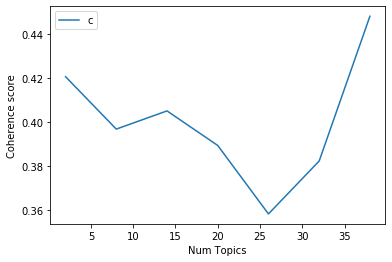

In [914]:
# Show graph
limit=40; start=2; step=6;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

en


'en'

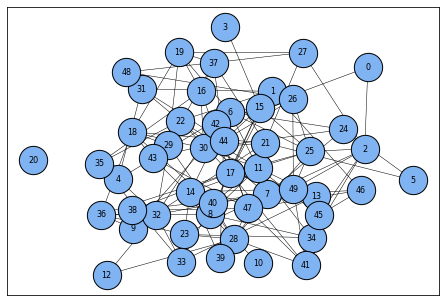

In [19]:
import networkx as nx
from dyngraphplot import DynGraphPlot

# create a random graph and plot it
G = nx.fast_gnp_random_graph(50, 0.1)
plot = DynGraphPlot(G)

# pause until "Enter" is pressed, as mode is non-blocking by default
input()

gcfh


'gcfh'

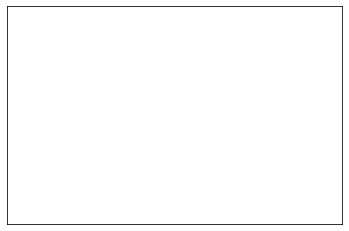

In [13]:
new_nodes = [50,51]
new_edges = [(50,20),(51,30), (50,51)]
plot.update(new_nodes, new_edges)

# wait before exiting
input()

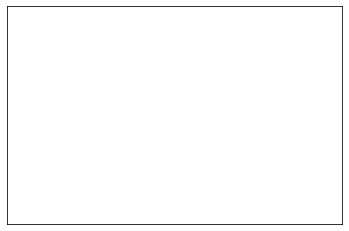

In [17]:
# update a plot, get result and close plot
new_nodes = [50,51]
new_G = plot.update(new_nodes)
new_layout = plot.layout
plot.close()

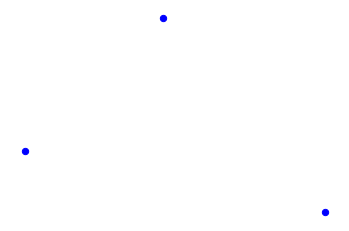

In [20]:
# other imports
import matplotlib.pyplot as plt
import numpy as np

# import the package
import forcelayout as fl

# Need a dataset to visualise
dataset = np.array([[1, 1],
                    [1, 3],
                    [2, 2]])

# Need to use the brute force algorithm on a dataset this small
# (not recommended for larger datasets)
layout = fl.draw_spring_layout(dataset=dataset, algorithm=fl.SpringForce)

plt.show()

In [21]:
import networkx as nx

G = nx.DiGraph()
edges = [
    ('a', 'a', 1),
    ('a', 'b', 5),
    ('a', 'c', 2),
    ('b', 'a', 2),
    ('b', 'c', 1),
    ]
for (u, v, w) in edges:
    G.add_edge(u, v, penwidth=w)

In [22]:
nx.nx_pydot.write_dot(G, '/tmp/graph.dot')

FileNotFoundError: [Errno 2] No such file or directory: '/tmp/graph.dot'